In [1]:
%pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 15.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import Chem
from rdkit.Chem import Descriptors

# Load the logP_synthetic dataset
data = pd.read_csv('logP_synthetic_dataset(1).csv', header=None, names=['SMILES', 'logP'])

# Function to compute molecular descriptors from SMILES
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(6)  # Return a zero vector if SMILES is invalid
    descriptors = [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)  # LogP of the molecule
    ]
    return descriptors

# Apply descriptor computation to the SMILES column
X = np.array([compute_descriptors(smiles) for smiles in data['SMILES']])
y = data['logP'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and reshape for LSTM
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add time dimension
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 200, num_layers=5, batch_first=True)  # 5 LSTM layers with 200 neurons each
        self.fc = nn.Linear(200, 1)  # Output layer with 1 neuron

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the output of the last time step
        return x

# Initialize LSTM model
input_dim = X_train.shape[1]
lstm_model = LSTMModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the LSTM model
epochs = 500
accuracy_threshold = 0.5
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    predictions = lstm_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Compute accuracy during training
    train_accuracy = torch.mean((torch.abs(predictions - y_train_t) < accuracy_threshold).float()).item()
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    lstm_model.eval()
    with torch.no_grad():
        test_preds = lstm_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = torch.mean((torch.abs(test_preds - y_test_t) < accuracy_threshold).float()).item()

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the LSTM model
lstm_model.eval()
lstm_preds = lstm_model(X_test_t).detach().numpy().flatten()
lstm_r2 = r2_score(y_test, lstm_preds)
lstm_mse = mean_squared_error(y_test, lstm_preds)
lstm_accuracy = np.mean(np.abs(lstm_preds - y_test) < accuracy_threshold)

# Display performance metrics
print(f"LSTM - R^2: {lstm_r2:.2f}, MSE: {lstm_mse:.2f}, Accuracy: {lstm_accuracy:.2f}")

# Plot results
import matplotlib.pyplot as plt

def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name}: Accuracy")
    plt.legend()

    plt.show()

# Plot results for LSTM
plot_results("LSTM", y_test, lstm_preds, train_losses, test_losses, train_accuracies, test_accuracies)


FileNotFoundError: [Errno 2] No such file or directory: 'logP_synthetic_dataset(1).csv'

In [ ]:
# 10. Residual Analysis
residuals = np.array(true_vals) - np.array(preds)

# Histogram of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='darkorange')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Residual Standard Error (RSE)
n = len(true_vals)
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
rse = np.sqrt(np.sum(residuals**2) / (n - p))

print(f"📊 Residual Standard Error (RSE): {rse:.4f}")

NameError: name 'plt' is not defined

Epoch 100/500, Loss: 4.4930, Accuracy: 0.2281
Epoch 200/500, Loss: 2.8354, Accuracy: 0.2846
Epoch 300/500, Loss: 2.0778, Accuracy: 0.3021
Epoch 400/500, Loss: 1.6827, Accuracy: 0.3353
Epoch 500/500, Loss: 1.4281, Accuracy: 0.4522
LSTM - R^2: 0.91, MSE: 1.43, Accuracy: 0.38


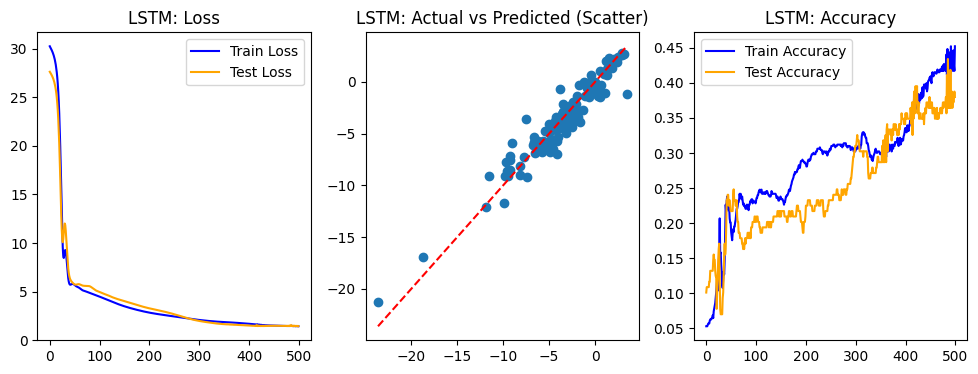

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('SAMPL(1).csv')

# Convert the 'expt' column to numeric and remove NaN values
data['expt'] = pd.to_numeric(data['expt'], errors='coerce')
data = data.dropna(subset=['expt'])

# Ensure valid SMILES strings
data = data[data['smiles'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

# Function to compute molecular descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(6)
    return [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)
    ]

# Apply descriptor computation
X = np.array([compute_descriptors(smiles) for smiles in data['smiles']])
y = data['expt'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and reshape for LSTM
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add time dimension
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 200, num_layers=5, batch_first=True)  # 5 LSTM layers with 200 neurons each
        self.fc = nn.Linear(200, 1)  # Output layer with 1 neuron

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the output of the last time step
        return x

# Initialize LSTM model
input_dim = X_train.shape[1]
lstm_model = LSTMModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the LSTM model
epochs = 500
accuracy_threshold = 0.5
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    predictions = lstm_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Compute accuracy during training
    train_accuracy = torch.mean((torch.abs(predictions - y_train_t) < accuracy_threshold).float()).item()
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    lstm_model.eval()
    with torch.no_grad():
        test_preds = lstm_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = torch.mean((torch.abs(test_preds - y_test_t) < accuracy_threshold).float()).item()

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the LSTM model
lstm_model.eval()
lstm_preds = lstm_model(X_test_t).detach().numpy().flatten()
lstm_r2 = r2_score(y_test, lstm_preds)
lstm_mse = mean_squared_error(y_test, lstm_preds)
lstm_accuracy = np.mean(np.abs(lstm_preds - y_test) < accuracy_threshold)

# Display performance metrics
print(f"LSTM - R^2: {lstm_r2:.2f}, MSE: {lstm_mse:.2f}, Accuracy: {lstm_accuracy:.2f}")

# Function to plot results
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name}: Accuracy")
    plt.legend()

    plt.show()

# Plot results for LSTM
plot_results("LSTM", y_test, lstm_preds, train_losses, test_losses, train_accuracies, test_accuracies)


Epoch 100/500, Loss: 0.8755, Accuracy: 0.3980
Epoch 200/500, Loss: 0.5927, Accuracy: 0.5166
Epoch 300/500, Loss: 0.4993, Accuracy: 0.5721
Epoch 400/500, Loss: 0.4538, Accuracy: 0.6009
Epoch 500/500, Loss: 0.4102, Accuracy: 0.6364
LSTM - R^2: 0.86, MSE: 0.68, Accuracy: 0.57


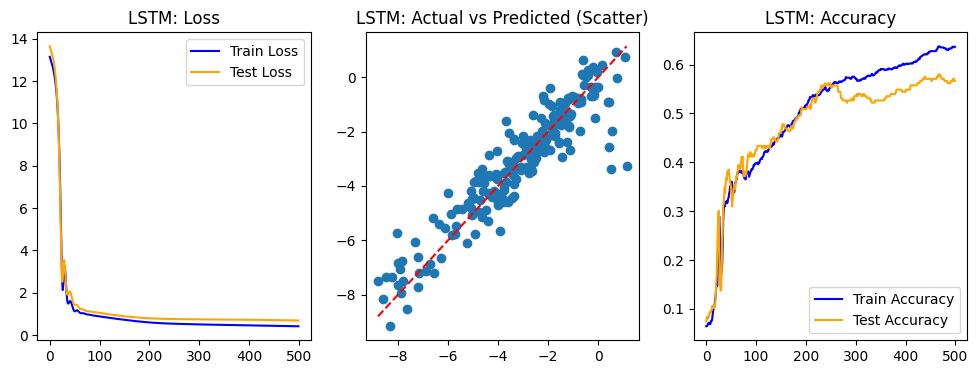

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('delaney-processed.csv')

# Convert the 'measured log solubility in mols per litre' column to numeric and remove NaN values
data['measured log solubility in mols per litre'] = pd.to_numeric(data['measured log solubility in mols per litre'], errors='coerce')
data = data.dropna(subset=['measured log solubility in mols per litre'])

# Ensure valid SMILES strings
data = data[data['smiles'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

# Function to compute molecular descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(6)
    return [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)
    ]

# Apply descriptor computation
X = np.array([compute_descriptors(smiles) for smiles in data['smiles']])
y = data['measured log solubility in mols per litre'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and reshape for LSTM
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add time dimension
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 200, num_layers=5, batch_first=True)  # 5 LSTM layers with 200 neurons each
        self.fc = nn.Linear(200, 1)  # Output layer with 1 neuron

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the output of the last time step
        return x

# Initialize LSTM model
input_dim = X_train.shape[1]
lstm_model = LSTMModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the LSTM model
epochs = 500
accuracy_threshold = 0.5
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    predictions = lstm_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Compute accuracy during training
    train_accuracy = torch.mean((torch.abs(predictions - y_train_t) < accuracy_threshold).float()).item()
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    lstm_model.eval()
    with torch.no_grad():
        test_preds = lstm_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = torch.mean((torch.abs(test_preds - y_test_t) < accuracy_threshold).float()).item()

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the LSTM model
lstm_model.eval()
lstm_preds = lstm_model(X_test_t).detach().numpy().flatten()
lstm_r2 = r2_score(y_test, lstm_preds)
lstm_mse = mean_squared_error(y_test, lstm_preds)
lstm_accuracy = np.mean(np.abs(lstm_preds - y_test) < accuracy_threshold)

# Display performance metrics
print(f"LSTM - R^2: {lstm_r2:.2f}, MSE: {lstm_mse:.2f}, Accuracy: {lstm_accuracy:.2f}")

# Function to plot results
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name}: Accuracy")
    plt.legend()

    plt.show()

# Plot results for LSTM
plot_results("LSTM", y_test, lstm_preds, train_losses, test_losses, train_accuracies, test_accuracies)


Epoch 100/500, Loss: 1.0366, Accuracy: 0.3613
Epoch 200/500, Loss: 1.0117, Accuracy: 0.3655
Epoch 300/500, Loss: 0.9856, Accuracy: 0.3777
Epoch 400/500, Loss: 0.9204, Accuracy: 0.3946
Epoch 500/500, Loss: 0.8611, Accuracy: 0.4229
LSTM - R^2: 0.36, MSE: 0.94, Accuracy: 0.43


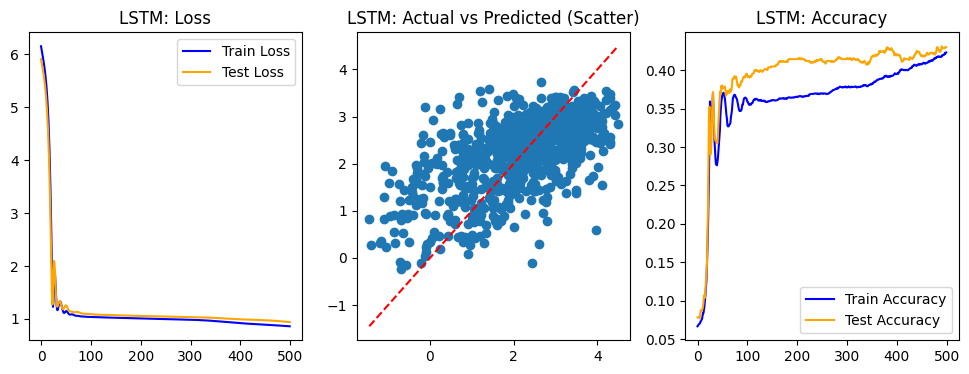

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt

# Load the Lipophilicity dataset
data = pd.read_csv('Lipophilicity.csv')

# Convert the 'exp' column to numeric and remove NaN values
data['exp'] = pd.to_numeric(data['exp'], errors='coerce')
data = data.dropna(subset=['exp'])

# Ensure valid SMILES strings
data = data[data['smiles'].apply(lambda x: Chem.MolFromSmiles(x) is not None)]

# Function to compute molecular descriptors
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(6)
    return [
        Descriptors.MolWt(mol),
        Descriptors.TPSA(mol),
        Descriptors.NumRotatableBonds(mol),
        Descriptors.NumHDonors(mol),
        Descriptors.NumHAcceptors(mol),
        Descriptors.MolLogP(mol)
    ]

# Apply descriptor computation
X = np.array([compute_descriptors(smiles) for smiles in data['smiles']])
y = data['exp'].values

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and reshape for LSTM
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add time dimension
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 200, num_layers=5, batch_first=True)  # 5 LSTM layers with 200 neurons each
        self.fc = nn.Linear(200, 1)  # Output layer with 1 neuron

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the output of the last time step
        return x

# Initialize LSTM model
input_dim = X_train.shape[1]
lstm_model = LSTMModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the LSTM model
epochs = 500
accuracy_threshold = 0.5
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    predictions = lstm_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Compute accuracy during training
    train_accuracy = torch.mean((torch.abs(predictions - y_train_t) < accuracy_threshold).float()).item()
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    lstm_model.eval()
    with torch.no_grad():
        test_preds = lstm_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = torch.mean((torch.abs(test_preds - y_test_t) < accuracy_threshold).float()).item()

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the LSTM model
lstm_model.eval()
lstm_preds = lstm_model(X_test_t).detach().numpy().flatten()
lstm_r2 = r2_score(y_test, lstm_preds)
lstm_mse = mean_squared_error(y_test, lstm_preds)
lstm_accuracy = np.mean(np.abs(lstm_preds - y_test) < accuracy_threshold)

# Display performance metrics
print(f"LSTM - R^2: {lstm_r2:.2f}, MSE: {lstm_mse:.2f}, Accuracy: {lstm_accuracy:.2f}")

# Function to plot results
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name}: Accuracy")
    plt.legend()

    plt.show()

# Plot results for LSTM
plot_results("LSTM", y_test, lstm_preds, train_losses, test_losses, train_accuracies, test_accuracies)


Epoch 100/500, Loss: 1.7713, Accuracy: 0.2380
Epoch 200/500, Loss: 1.7409, Accuracy: 0.2595
Epoch 300/500, Loss: 0.7097, Accuracy: 0.5331
Epoch 400/500, Loss: 0.0767, Accuracy: 0.9339
Epoch 500/500, Loss: 0.0210, Accuracy: 0.9860
LSTM - R^2: 0.80, MSE: 0.35, Accuracy: 0.74


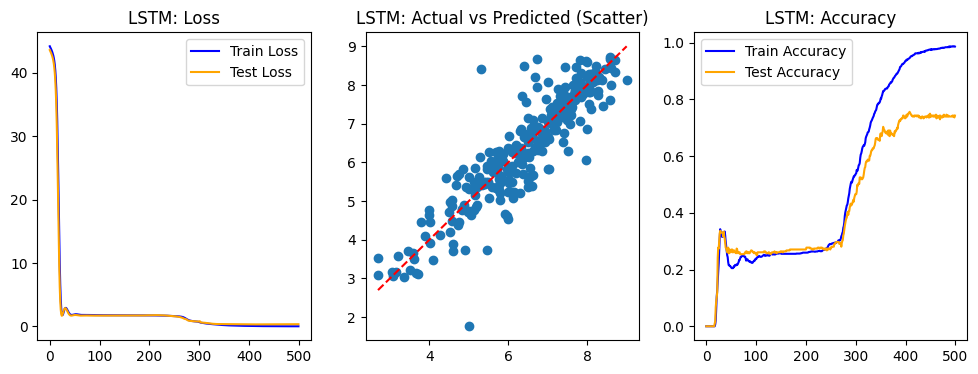

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Load BACE data
data = pd.read_csv('bace.csv')  # Ensure the file path is correct
data.columns = data.columns.str.strip()  # Clean any spaces in column names

# Data preprocessing: Select features and target variable
X = data.drop(columns=['pIC50', 'CID', 'mol', 'Class', 'Model'], errors='ignore')  # Adjust columns according to your data
y = data['pIC50']

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors and reshape for LSTM
X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add time dimension
X_test_t = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, 200, num_layers=5, batch_first=True)  # 5 LSTM layers with 200 neurons each
        self.fc = nn.Linear(200, 1)  # Output layer with 1 neuron

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])  # Take the output of the last time step
        return x

# Initialize LSTM model
input_dim = X_train.shape[1]
lstm_model = LSTMModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Train the LSTM model
epochs = 500
accuracy_threshold = 0.5
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    lstm_model.train()
    optimizer.zero_grad()
    predictions = lstm_model(X_train_t)
    loss = criterion(predictions, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Compute accuracy during training
    train_accuracy = torch.mean((torch.abs(predictions - y_train_t) < accuracy_threshold).float()).item()
    train_accuracies.append(train_accuracy)

    # Evaluate on test set
    lstm_model.eval()
    with torch.no_grad():
        test_preds = lstm_model(X_test_t)
        test_loss = criterion(test_preds, y_test_t)
        test_accuracy = torch.mean((torch.abs(test_preds - y_test_t) < accuracy_threshold).float()).item()

    test_losses.append(test_loss.item())
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}")

# Evaluate the LSTM model
lstm_model.eval()
lstm_preds = lstm_model(X_test_t).detach().numpy().flatten()
lstm_r2 = r2_score(y_test, lstm_preds)
lstm_mse = mean_squared_error(y_test, lstm_preds)
lstm_accuracy = np.mean(np.abs(lstm_preds - y_test) < accuracy_threshold)

# Display performance metrics
print(f"LSTM - R^2: {lstm_r2:.2f}, MSE: {lstm_mse:.2f}, Accuracy: {lstm_accuracy:.2f}")

# Function to plot results
def plot_results(model_name, y_test, preds, train_losses, test_losses, train_accuracies, test_accuracies):
    plt.figure(figsize=(12, 4))

    # Loss Graph (train vs test)
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label="Train Loss", color='blue')
    plt.plot(test_losses, label="Test Loss", color='orange')
    plt.title(f"{model_name}: Loss")
    plt.legend()

    # Actual vs Predicted Scatter
    plt.subplot(1, 3, 2)
    plt.scatter(y_test, preds)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.title(f"{model_name}: Actual vs Predicted (Scatter)")

    # Accuracy Graph (train vs test)
    plt.subplot(1, 3, 3)
    plt.plot(train_accuracies, label="Train Accuracy", color='blue')
    plt.plot(test_accuracies, label="Test Accuracy", color='orange')
    plt.title(f"{model_name}: Accuracy")
    plt.legend()

    plt.show()

# Plot results for LSTM
plot_results("LSTM", y_test, lstm_preds, train_losses, test_losses, train_accuracies, test_accuracies)
